In [41]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import platform
from sklearn import linear_model

In [42]:
def loadData(filename):
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    for lv in rd:
        data.append(lv)
    header = data[0]
    infectionData=(data[1:])
    infectionData = np.array(infectionData)
    dates = infectionData[:,0]
    dates = dates.tolist()
    infected = infectionData[:,1]
    tested = infectionData[:,2]
    recovered = infectionData[:,3]
    deaths = infectionData[:,4]
    deaths = deaths.astype(np.float)
    recovered = recovered.astype(np.float)
    tested = tested.astype(np.float)
    infected = infected.astype(np.float)
    return dates, infected, tested, recovered, deaths

In [49]:
# Modify the path syntax based on the current platform
if platform.system() == "Windows":
    pathc="..\\Data\\Italian Data\\"
elif platform.system() == "Linux":
    pathc="../Data/Italian Data/"
    
filename = "National Data.csv"

dates,infectRaw, natTested, recovRaw, deadRaw = loadData(pathc + filename)



In [47]:
if platform.system() == "Windows":
    pathc="..\\Data\\Italian Data\\"
elif platform.system() == "Linux":
    pathc="../Data/Italian Data/"
    
filename = "National Data(Weeks).csv"

dates,infectRaw, natTested, recovRaw, deadRaw = loadData(pathc + filename)


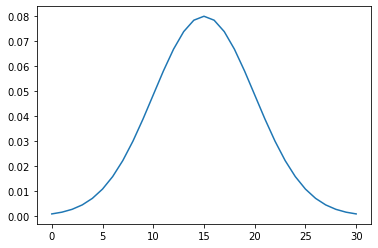

In [44]:
sigma = 5
conSize = 15
x2 = np.arange(-conSize, 1 + conSize)
kernel2 = np.exp(-(x2) ** 2 / (2 * sigma ** 2))
kernel2=kernel2/sum(kernel2)
plt.plot(kernel2)

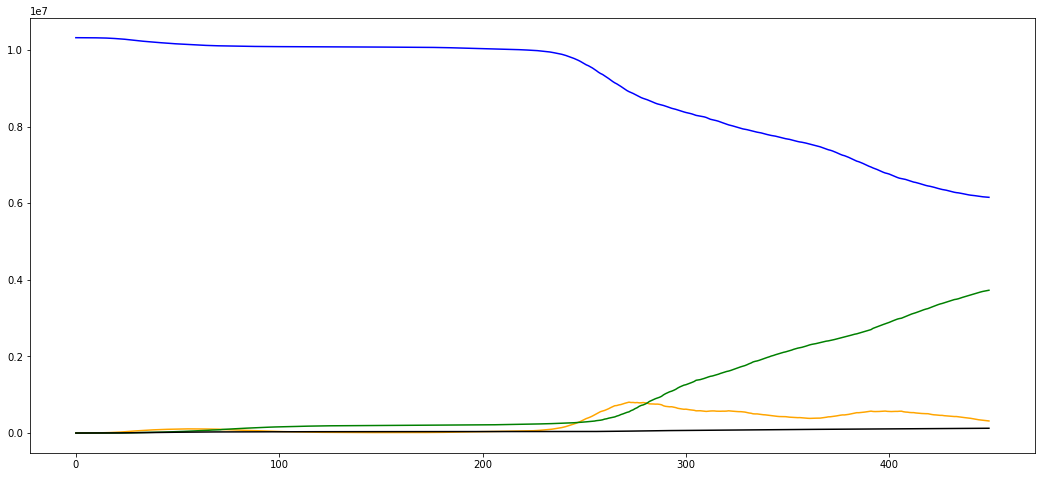

In [50]:

popITA = 60000000


q = .172
#since S+I+R+D always equals the same constant S(t) can now be determined
susceptRaw = q*popITA - infectRaw - recovRaw - deadRaw

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(susceptRaw, color='blue', label='suscpetible') #graphing susceptible makes the scaling to hard to visualize
#ax.plot(natTested, color = 'red', label = 'tested') #graphing tested makes the scaling hard to visualize
ax.plot(infectRaw, color='orange', label='infected')
ax.plot(recovRaw, color='green', label='recovered')
ax.plot(deadRaw, color='black', label='dead')

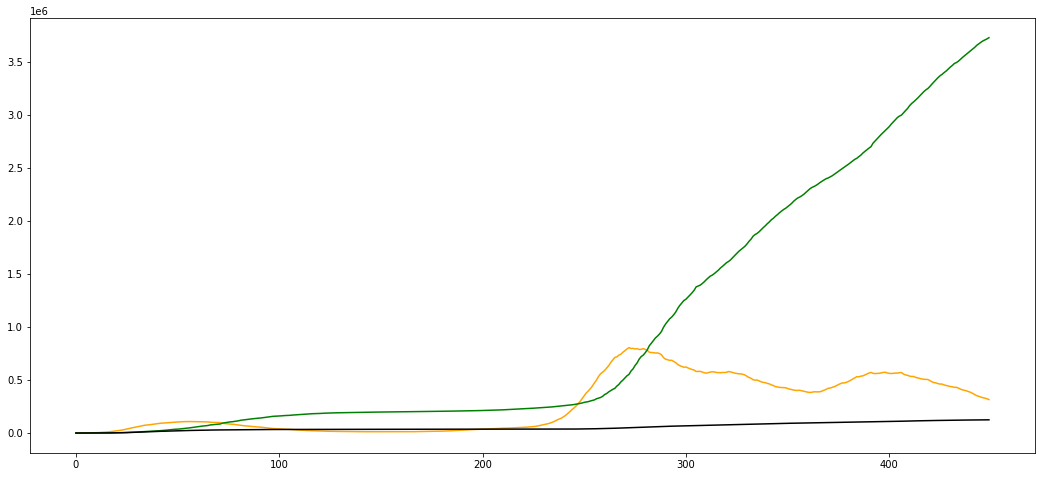

In [137]:
#option for use of raw numbers for data, no smoothing
infect = infectRaw
recov = recovRaw
dead = deadRaw
suscept = susceptRaw

#convolve the data to smooth out, valid mode keeps bound points realistic
#infect = np.convolve(infectRaw, kernel2, 'valid')
#recov = np.convolve(recovRaw, kernel2, 'valid')
#dead = np.convolve(deadRaw, kernel2, 'valid')
#suscept = popITA - infect - recov - dead #S + I + R + D = totalPop

fig, ax = plt.subplots(figsize=(18,8))
#ax.plot(suscept, color='blue', label='suscpetible') #graphing susceptible makes the scaling to hard to visualize
ax.plot(infect, color='orange', label='infected')
ax.plot(recov, color='green', label='recovered')
ax.plot(dead, color='black', label='dead')

### Modeling $\gamma$ (recovery rate), $\beta$ (transmission rate), and $\upsilon$ (death rate).

$S(t+1) = -\beta \frac{S(t)I(t)}{S(t)+I(t)} + S(t)$

$I(t+1) = \beta \frac{S(t)I(t)}{S(t)+I(t)} - \gamma I(t) - \upsilon I(t) + I(t)$

$R(t+1) = \gamma I(t) + R(t)$

$D(t+1) = \upsilon I(t) + D(t)$

### As a matrix

$\begin{bmatrix}
S(t+1) - S(t) \\ I(t+1) - I(t) \\ R(t+1) - R(t) \\ D(t+1) - D(t)
\end{bmatrix}
=
\begin{bmatrix}
-\frac{S(t)I(t)}{S(t)+I(t)} & 0 & 0 \\
\frac{S(t)I(t)}{S(t)+I(t)} & -I(t) & -I(t) \\
0 & I(t) & 0 \\
0 & 0 & I(t)
\end{bmatrix}
\begin{bmatrix}
\beta \\ \gamma \\ \upsilon
\end{bmatrix}$

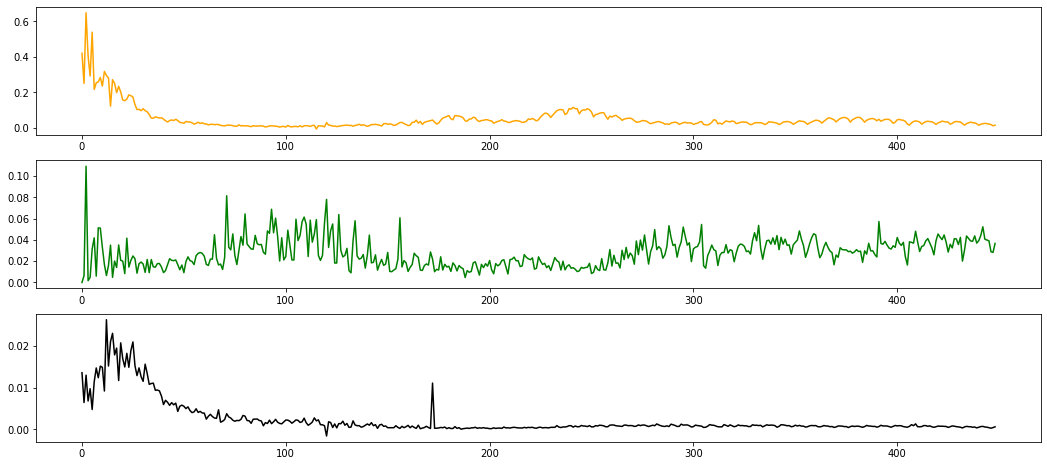

In [156]:
def getSIRDMatrices(suscept, infect, recov, dead):
    sirdMatrix = np.zeros((4, 3, len(recov) - 1))
    nextIterMatrix = np.zeros((4, 1, len(recov) - 1)) #the S(t+1), I(t+1), ... matrix

    #populate the 4x4 matrix with parameters (see above note)
    sirdMatrix[0,0] = -(suscept[0:-1] * infect[0:-1]) / (suscept[0:-1] + infect[0:-1])

    sirdMatrix[1,0] = (suscept[0:-1] * infect[0:-1]) / (suscept[0:-1] + infect[0:-1])
    sirdMatrix[1,1] = -infect[0:-1]
    sirdMatrix[1,2] = -infect[0:-1]

    sirdMatrix[2,1] = infect[0:-1]

    sirdMatrix[3,2] = infect[0:-1]

    #populate the S(t+1), I(t+1), ... matrix
    nextIterMatrix[0,0] = suscept[1:] - suscept[0:-1]
    nextIterMatrix[1,0] = infect[1:] - infect[0:-1]
    nextIterMatrix[2,0] = recov[1:] - recov[0:-1]
    nextIterMatrix[3,0] = dead[1:] - dead[0:-1]

    return nextIterMatrix, sirdMatrix

nextIterMatrix, sirdMatrix = getSIRDMatrices(suscept, infect, recov, dead)

paramMatrix = np.zeros((3, np.shape(sirdMatrix)[2]))
for i in range(np.shape(sirdMatrix)[2]):
    paramMatrix[:,i] = np.linalg.lstsq(sirdMatrix[:,:,i], nextIterMatrix[:,:,i], rcond=0)[0].flatten() #solve Ax = B, where A = sirdMatrix, and B = nextIterMatrix
    
#copy params over from the solved matrix
transRate = paramMatrix[0] #beta
recovRate = paramMatrix[1] #gamma
deathRate = paramMatrix[2] #upsilon

#plot rates over time
fig, ax = plt.subplots(3, 1, figsize=(18,8))
ax[0].plot(transRate, color='orange', label='Transmission Rate')
ax[1].plot(recovRate, color='green', label='Recovery Rate')
ax[2].plot(deathRate, color='black', label='Death Rate')

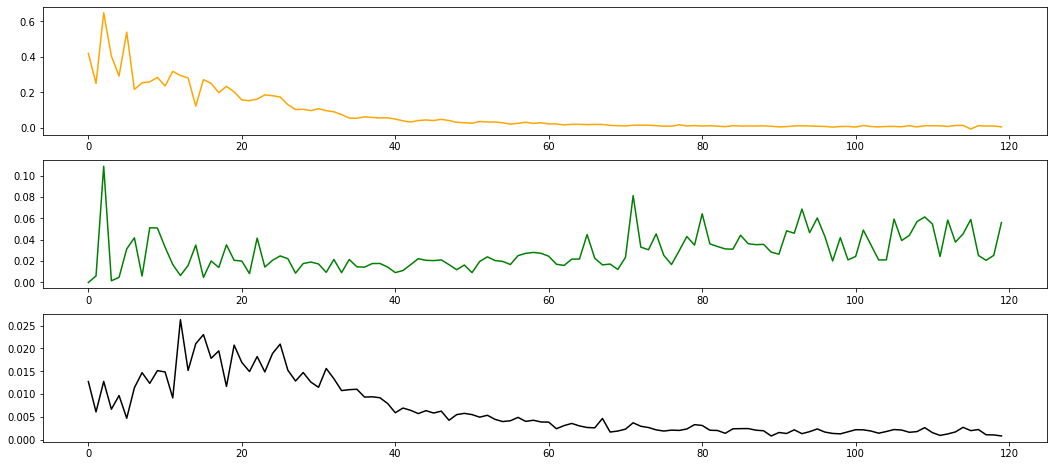

In [148]:
transRateSect = transRate[0:120]
recovRateSect = recovRate[0:120]
deathRateSect = deathRate[0:120]

#graph only the first 120 days
fig, ax = plt.subplots(3, 1, figsize=(18,8))
ax[0].plot(transRateSect, color='orange', label='Transmission Rate')
ax[1].plot(recovRateSect, color='green', label='Recovery Rate')
ax[2].plot(deathRateSect, color='black', label='Death Rate')

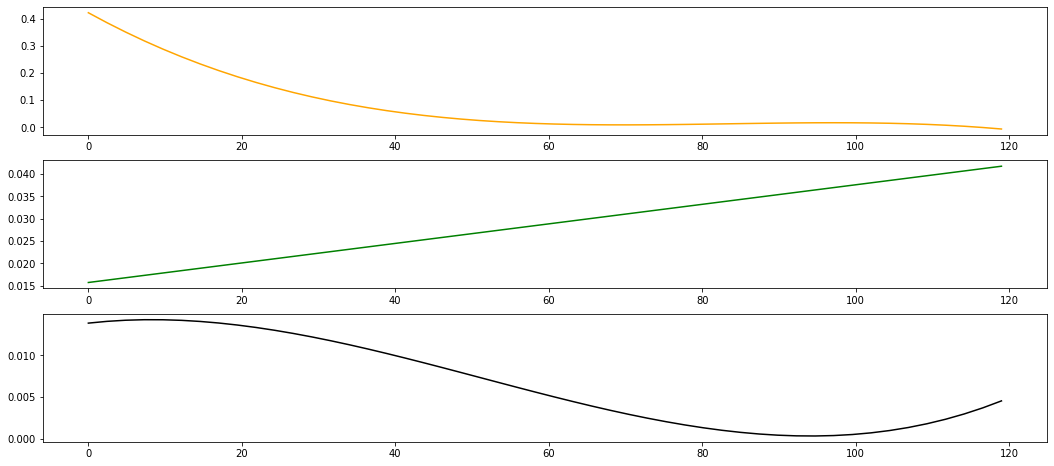

In [140]:
fig, ax = plt.subplots(3, 1, figsize=(18,8))

x=range(0, len(transRateSect))
xPlot = np.linspace(x[0], x[-1])

poly = np.poly1d(np.polyfit(x, transRateSect, 3))
yPlot = poly(xPlot)
ax[0].plot(xPlot, yPlot, color='orange', label='Transmission Rate')

poly = np.poly1d(np.polyfit(x, recovRateSect, 1))
yPlot = poly(xPlot)
ax[1].plot(xPlot, yPlot, color='green', label='Recovery Rate')

poly = np.poly1d(np.polyfit(x, deathRateSect, 3))
yPlot = poly(xPlot)
ax[2].plot(xPlot, yPlot, color='black', label='Death Rate')

best q: 0.1283


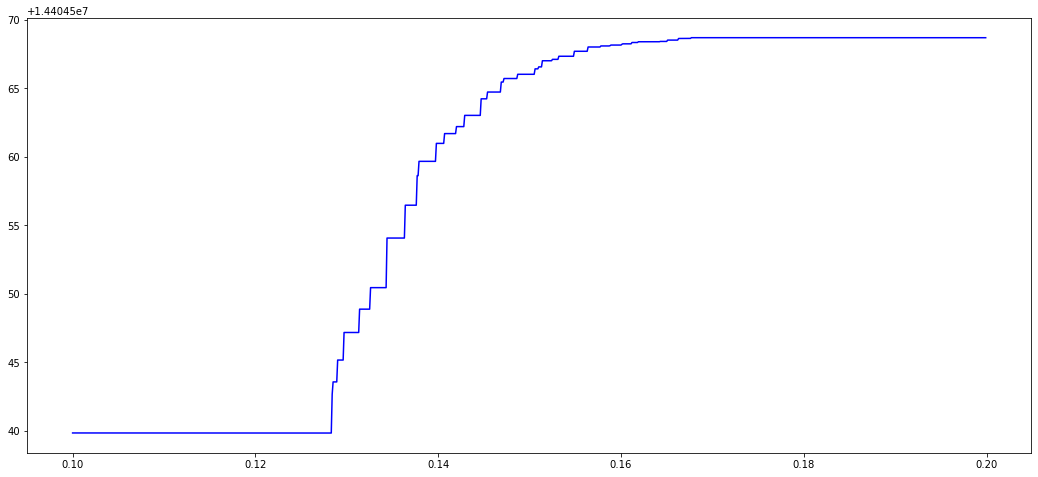

In [39]:
popITA = 60000000
resol = 1000 #how many values of q to graph
qList = np.zeros(resol)
qMin = 0.1
qMax = 0.2
minCostList = np.zeros(resol)
for i in range(resol):
    qList[i] = qMin + (i/resol)*(qMax-qMin) #go from 0 to 1

lamda = 10
model = linear_model.Lasso(alpha=lamda)
w = .9

for i in range(resol):
    suscept = qList[i]*popITA - infect - recov - dead
    nextIterMatrix, sirdMatrix = getSIRDMatrices(suscept, infect, recov, dead)
    T = np.shape(sirdMatrix)[2]
    paramMatrix = np.zeros((3, T))
    totalLoss = 0
    for t in range(T):
        model.fit(sirdMatrix[:,:,t], nextIterMatrix[:,:,t])
        paramMatrix[:,t] = model.coef_

        iterLoss = w**(T-t) * np.linalg.norm(nextIterMatrix[:,:,t] - sirdMatrix[:,:,t]*paramMatrix[:,t], ord=2)**2 + lamda*np.linalg.norm(paramMatrix[:,t], ord=1)
        totalLoss = totalLoss + iterLoss

    totalLoss = totalLoss / (T)
    minCostList[i] = totalLoss
    
bestQIndex = 0
for i in range(resol):
    if(minCostList[bestQIndex] > minCostList[i]):
        bestQIndex = i
    
print("best q:", qList[bestQIndex])
    
fig, ax = plt.subplots(figsize=(18,8))
ax.plot(qList, minCostList, color='blue')

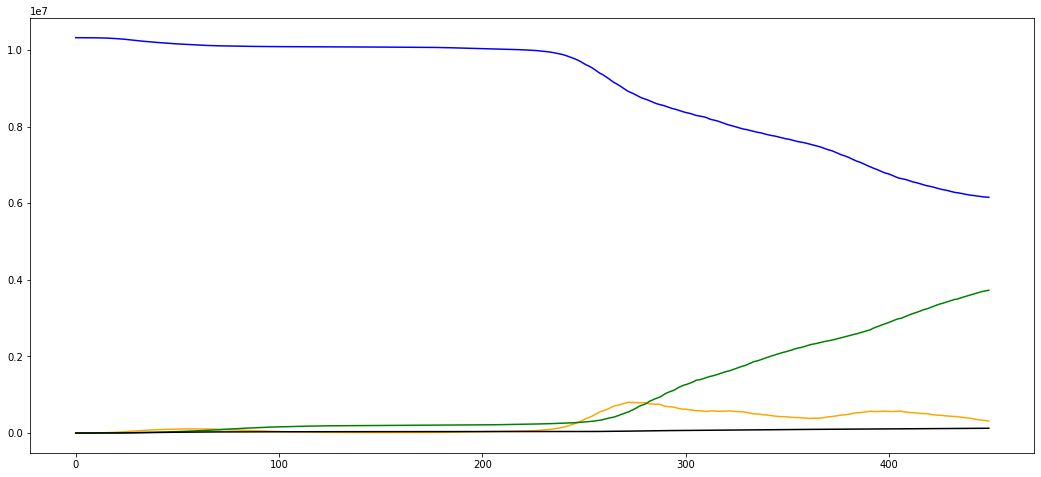

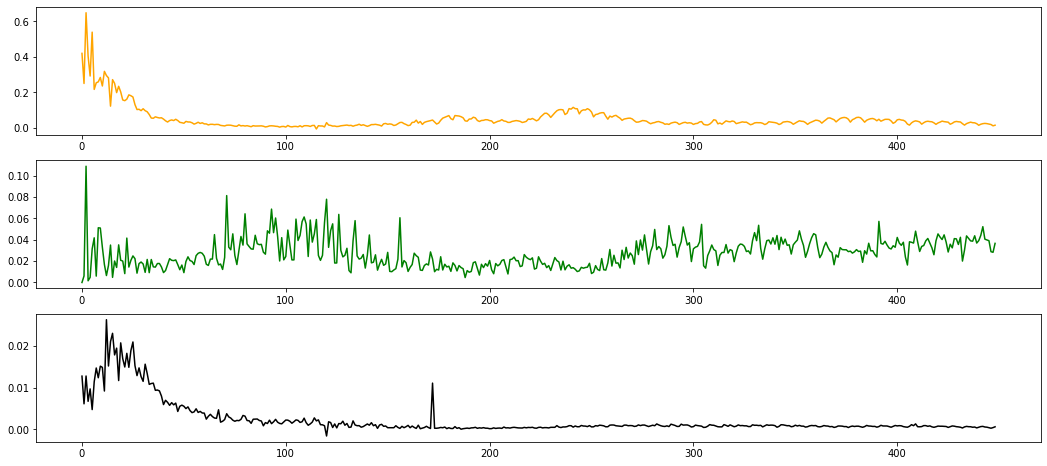

In [151]:
lamda = 10
model = linear_model.Lasso(alpha=lamda)
q = .128

suscept = q*popITA - infect - recov - dead
nextIterMatrix, sirdMatrix = getSIRDMatrices(suscept, infect, recov, dead)

T = np.shape(sirdMatrix)[2]
paramMatrix = np.zeros((3, T))
for t in range(T):
    model.fit(sirdMatrix[:,:,t], nextIterMatrix[:,:,t])
    paramMatrix[:,t] = model.coef_

#plot SIRD graph
fig, ax = plt.subplots(figsize=(18,8))
ax.plot(susceptRaw, color='blue', label='suscpetible') #graphing susceptible makes the scaling to hard to visualize
#ax.plot(natTested, color = 'red', label = 'tested') #graphing tested makes the scaling hard to visualize
ax.plot(infectRaw, color='orange', label='infected')
ax.plot(recovRaw, color='green', label='recovered')
ax.plot(deadRaw, color='black', label='dead')
    
#copy params over from the solved matrix
transRate = paramMatrix[0] #beta
recovRate = paramMatrix[1] #gamma
deathRate = paramMatrix[2] #upsilon

#plot rates over time
fig2, ax2 = plt.subplots(3, 1, figsize=(18,8))
ax2[0].plot(transRate, color='orange', label='Transmission Rate')
ax2[1].plot(recovRate, color='green', label='Recovery Rate')
ax2[2].plot(deathRate, color='black', label='Death Rate')